# **Tutorial 4** - Geophysics (Seismology)

In this tutorial we will learn how to

 1. Prepare **gridded data**: [`pygmt.xyz2grd`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.xyz2grd.html)
 2. Create a **contour map**: [`pygmt.Figure.grdcontour`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.grdcontour.html)
 3. Create a **profile plot**: [`pygmt.project`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.project.html) and [`pygmt.grdtrack`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grdtrack.html)

-----
This tutorial is part of the AGU2024 annual meeting GMT/PyGMT pre-conference workshop (PREWS9) **Mastering Geospatial Visualizations with GMT/PyGMT**
- Conference: https://agu.confex.com/agu/agu24/meetingapp.cgi/Session/226736
- GitHub: https://github.com/GenericMappingTools/agu24workshop
- Website: https://www.generic-mapping-tools.org/agu24workshop
- Recommended version: PyGMT v0.13.0 with GMT 6.5.0

## 0. General stuff

Import the required packages. Besides [`PyGMT`](https://www.pygmt.org/v0.13.0) we also use [`NumPy`](https://numpy.org/doc/stable/).

In [1]:
import pygmt
import numpy as np
import pandas as pd 

## 1. Prepare gridded data: [`pygmt.xyz2grd`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.xyz2grd.html)

Sometimes, we will access the spatial (regional or global) data such as .txt or .csv containing x, y, and z columns.

In [2]:
# reading file
data = np.loadtxt("south_america_topography_05m.txt")

print(type(data))
print(data)

<class 'numpy.ndarray'>
[[  -90.             0.         -1033.5       ]
 [  -89.91666667     0.         -1132.5       ]
 [  -89.83333333     0.         -1298.        ]
 ...
 [  -60.16666667   -40.           -50.        ]
 [  -60.08333333   -40.           -52.        ]
 [  -60.           -40.           -54.        ]]


We can convert `numpy.ndarray` to a grid, and you need to provide:

1. `data` or `x`, `y`, `z`: Input text file. Importantly, if you use `data`, the columns order must be longitude, latitude, and data. Otherwise, you should use `x`, `y`, and `z` to individually define the dataset. 
2. `region`: Specifies the grid's geographical region in the form [xmin, xmax, ymin, ymax].
3. `spacing`: Grid spacing for the output grid. In our case, the spacing of original dataset is `5m`, we do not interpolate to better resolution, otherwise, it might cause data distortion. 

In [3]:
region = [-90, -60, -40, 0]  

grid = pygmt.xyz2grd(data = data, spacing="5m", region=region)
print(pygmt.grdinfo(grid))

: Title: 
: Command: 
: Remark: 
: Gridline node registration used [Geographic grid]
: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
: x_min: -90 x_max: -60 x_inc: 0.0833333333333 (5 min) name: x n_columns: 361
: y_min: -40 y_max: 0 y_inc: 0.0833333333333 (5 min) name: y n_rows: 481
: v_min: -7816.5 v_max: 5798.5 name: z
: scale_factor: 1 add_offset: 0
: format: classic
: Default CPT: 



In [4]:
grid

<xarray.DataArray 'z' (lat: 481, lon: 361)> Size: 1MB
array([[-3470.5, -3474. , -3455.5, ...,   -50. ,   -52. ,   -54. ],
       [-3447.5, -3438.5, -3436. , ...,   -46. ,   -50.5,   -51. ],
       [-3440.5, -3419.5, -3419. , ...,   -44.5,   -49. ,   -51. ],
       ...,
       [ -970. , -1083. , -1261.5, ...,   114. ,   126.5,   129. ],
       [ -959. , -1044. , -1204. , ...,   110.5,   124.5,   146. ],
       [-1033.5, -1132.5, -1298. , ...,   108. ,   117. ,   141. ]])
Coordinates:
  * lat      (lat) float64 4kB -40.0 -39.92 -39.83 ... -0.1667 -0.08333 0.0
  * lon      (lon) float64 3kB -90.0 -89.92 -89.83 ... -60.17 -60.08 -60.0
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt xyz2grd @GMTAPI@-S-I-D-M-T-N-000000 -G@GMTAPI@-S-O-G-G...
    description:   
    long_name:     z
    actual_range:  [nan nan]

## 2. Create a contour map: [`pygmt.Figure.grdcontour`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.grdcontour.html)
Convert grids or images to contours and plot them on maps

you need to define:
1. `grid`: Accessing the remote datasets or providing your dataset as ``xarray.DataArray``
2. `level`: Specify the contour intervals to generate; for example, value of 1000 means plotting contour lines at every 1000 m.
3. `annotation`: Annotated contour levels
4. `limit`: Draw contours below low or above high, e.g, [-4000, 0] means drawing contour lines below sea level and above -4000 m.

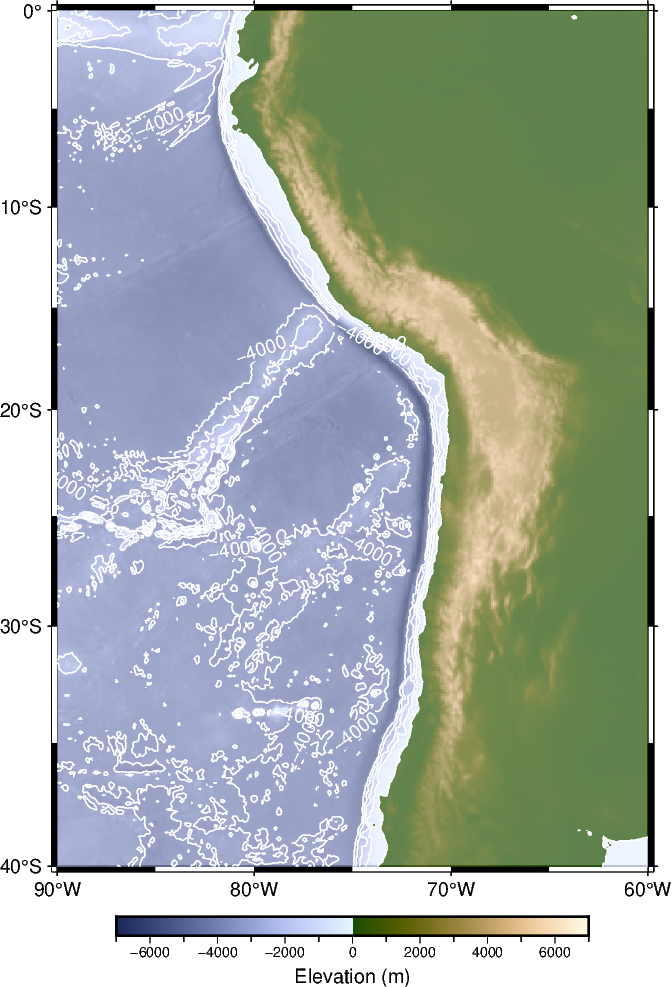

In [5]:
fig = pygmt.Figure()
fig.basemap(projection="M10c", region=region, frame=["a10f5"])

pygmt.makecpt(cmap="oleron", series=[-7000, 7000])
fig.colorbar(frame=["xa2000f1000+lElevation (m)"])

fig.grdimage(grid=grid, cmap=True, transparency=30)

fig.grdcontour(grid=grid, annotation=2000, levels=1000, limit=[-4000, 0], pen="0.5p,white")

fig.show(dpi=150)

## 3. Create a profile plot: [`pygmt.project`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.project.html) and [`pygmt.grdtrack`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grdtrack.html)

`pygmt.project` is designed to sample points along a great circle, a straight line, or across specified distance. 
In our case, we will create a profile by point-to-point, you need to define
1. `center` and `endpoint`: specify the start and end coordinates of the profile
2. `generate`: distance interval of each point. e.g., `10` means points are generated every 10 degrees along the profile. 
3. `unit` (option): By default, `unit=False`, the distances of points along the profile are measured in degrees. When `unit=True` is used, it specifies that the distances are generated in kilometers. 

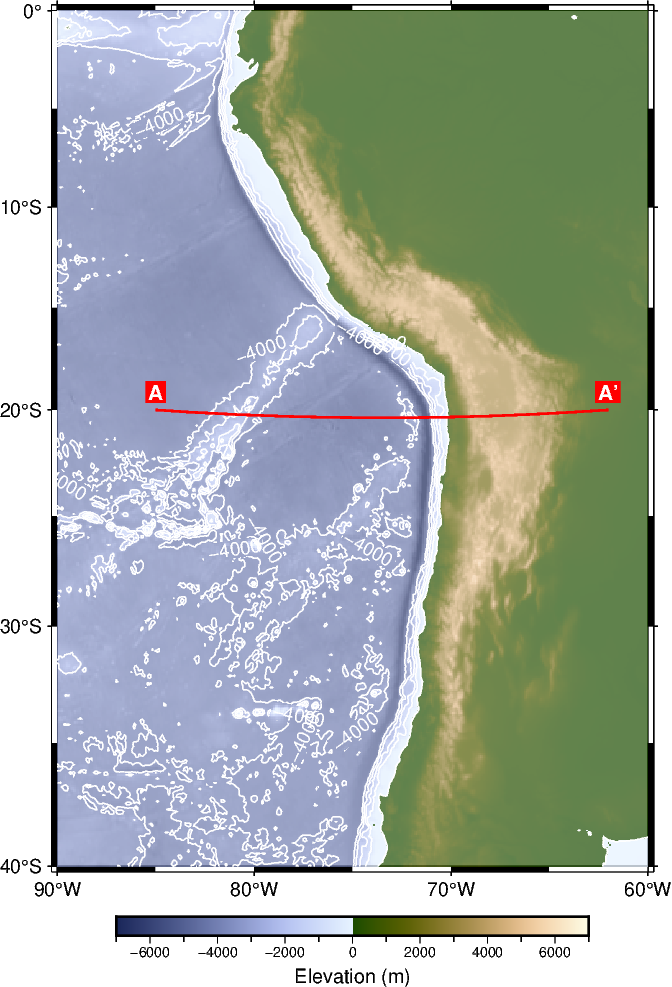

In [6]:
# Choose a survey line
start_x = -85  # Longitude in degrees East
start_y = -20  # Latitude in degrees North
end_x = -62
end_y= -20

# Plot the survey line
fig.plot(x=[start_x, end_x],  y=[start_y, end_y], pen="1p,red")

fig.text(
    x=[start_x, end_x], 
    y=[start_y, end_y],
    text=["A", "A'"],
    offset="0c/0.3c", 
    font="10p,1,white",
    fill="red",
)

track_df = pygmt.project(
    center=[start_x, start_y], 
    endpoint=[end_x, end_y], 
    # Output data in steps of 1 km with setting unit=True
    generate="1", 
    unit=True,
)

fig.show(dpi=150)

In [7]:
track_df.head()

,r,s,p
0,-85.000000,-20.000000,0.0
1,-84.990453,-20.000624,1.0
2,-84.980905,-20.001248,2.0
3,-84.971358,-20.001871,3.0
4,-84.961810,-20.002493,4.0


**NOTE**: the output format is `pandas.DataFrame`, and **r** and **s** together provide the geographic coordinates (longitude, latitude) of each point along the track, while **p** gives the cumulative distance along the profile up to each point. 


Then, we use `pygmt.grdtrack` to sample topographic (or other grid-based data) values along a profile that you generated using `pygmt.project`. This allows you to retrieve data from a grid file along a specified path. 

Therefore, you need to provide

1. `grid`: Specifies the grid file (e.g., a topographic grid) from which data will be sampled
2. `point`: Provides the coordinates of the profile points
3. `newcolname`: Name for the new column with sampled values

In [8]:
# Extract the elevation at the generated points from the downloaded grid
# and add it as new column "elevation" to the pandas.DataFrame
track_df = pygmt.grdtrack(grid=grid, points=track_df, newcolname="elevation")

In [9]:
track_df.head()

,r,s,p,elevation
0,-85.000000,-20.000000,0.0,-4440.500000
1,-84.990453,-20.000624,1.0,-4445.130540
2,-84.980905,-20.001248,2.0,-4450.944209
3,-84.971358,-20.001871,3.0,-4457.558040
4,-84.961810,-20.002493,4.0,-4464.581447


**Note**: the new column is **elevation** to indicate the elevation variation along the track

Now, we add addtional different size panel to visualize the topography. 
The first thing is observe the minimum and maximum of data. 


In [10]:
print(min(track_df["elevation"]), max(track_df["elevation"]))

-7319.553238186646 4422.575285314326


Then, using [`figure.shift_origin`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.shift_origin.html) to shift [`figure.basemap`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.basemap.html) to avoid orignal figure. 

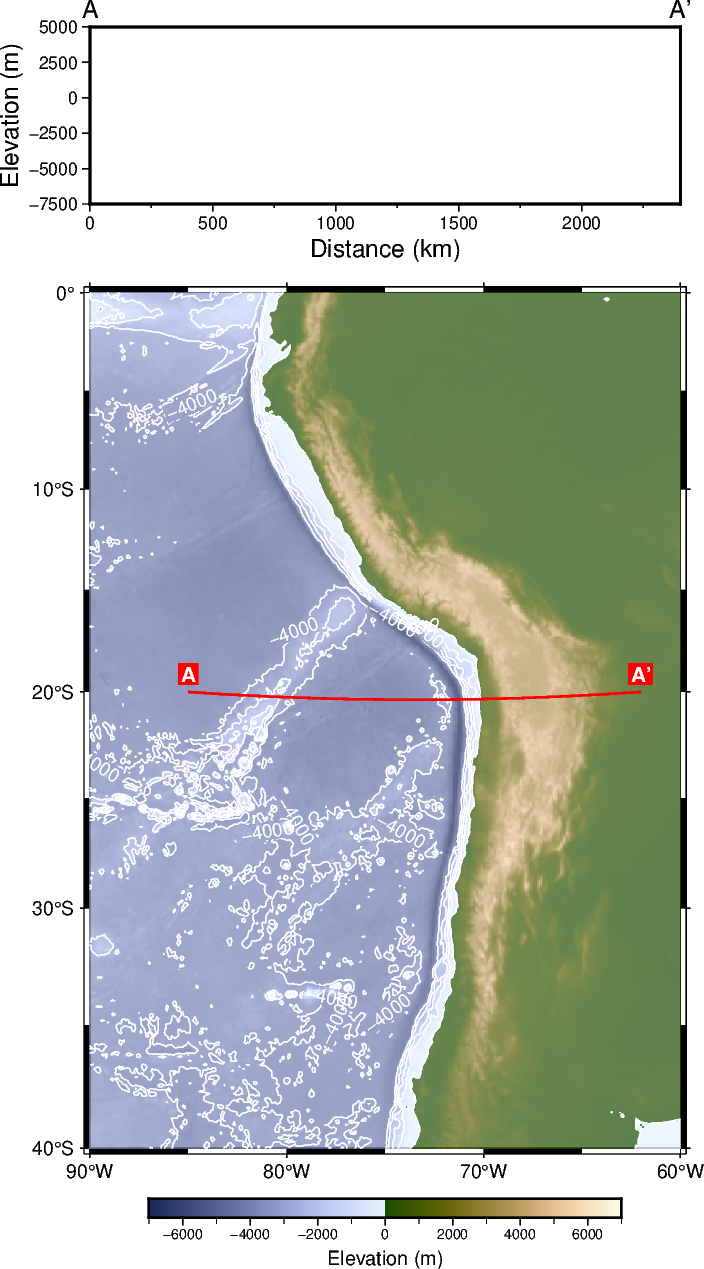

In [11]:
fig.shift_origin(yshift="h+1.5c")

fig.basemap(
    region=[0, max(track_df["p"]), -7500, 5000],
    # Cartesian projection with a width of 12 centimeters and a height of 3 centimeters
    projection="X10c/3c",
    frame=["WSrt", "xa500f250+lDistance (km)", "ya2500+lElevation (m)"],
)

fig.text(
    x=[0, max(track_df["p"])],
    y=[5000, 5000],
    text=["A", "A'"],
    offset='0c/0.3c',
    no_clip=True,  # Do not clip text that fall outside the plot bounds
    font="12p"
)

fig.show(dpi=150)

Coloring the land in lightgray and the ocean in lightblue according to the profile variation

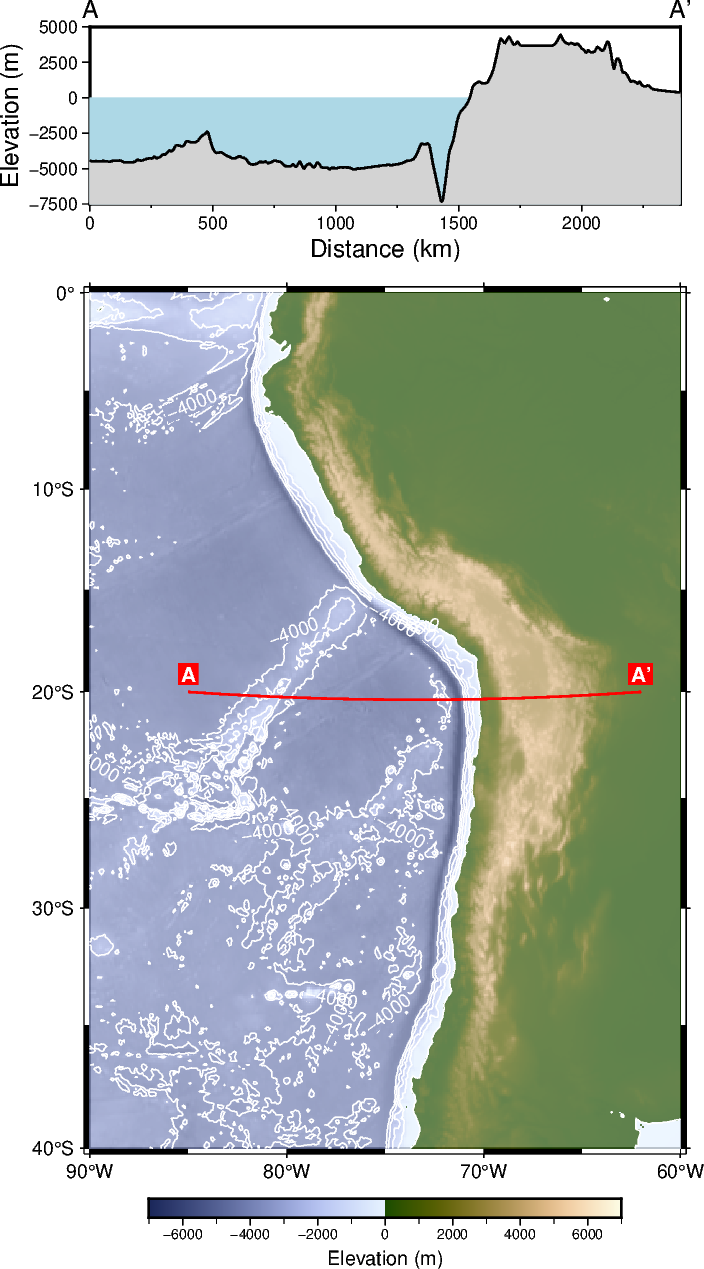

In [12]:
# Plot water masses
fig.plot(
    x=[0, max(track_df["p"])],
    y=[0, 0],
    fill="lightblue",  # Fill the polygon in "lightblue"
    close="+y-7500",  # Force closed polygon
)

# Plot elevation along the survey line
fig.plot(
    x=track_df["p"],
    y=track_df["elevation"],
    fill="lightgray",  # Fill the polygon in "gray"
    # Draw a 1-point thick, black, solid outline
    pen="1p,black,solid",
    close="+y-7500",  # Force closed polygon
)

fig.show(dpi=150)

## 4. Add additional features

### 4.1 Add seismicity

## need to add note
seismicity archived from obspy 

t1 = UTCDateTime("2022-01-01")
t2 = UTCDateTime("2023-01-01") 
cat = client.get_events(starttime=t1, endtime=t2, minlatitude=-40, maxlatitude=0, minlongitude=-90, maxlongitude=-60)

In [13]:
fig.shift_origin(yshift="-16c")  # Manually adjusted
fig.basemap(projection="M10c", region=region, frame="rltb")

df = pd.read_csv('seismicity_2022.csv')
df.head()

,time,lon,lat,depth,mag
0,2022-12-31T23:04:12.784000Z,-69.6800,-16.5378,196.743,4.9
1,2022-12-31T12:47:57.842000Z,-71.5625,-32.2686,48.300,4.5
2,2022-12-31T03:31:43.830000Z,-68.8969,-23.1036,96.224,5.1
3,2022-12-31T00:43:57.999000Z,-77.7617,-1.7451,182.543,4.3
4,2022-12-30T22:35:25.866000Z,-67.1397,-24.0267,232.941,4.5


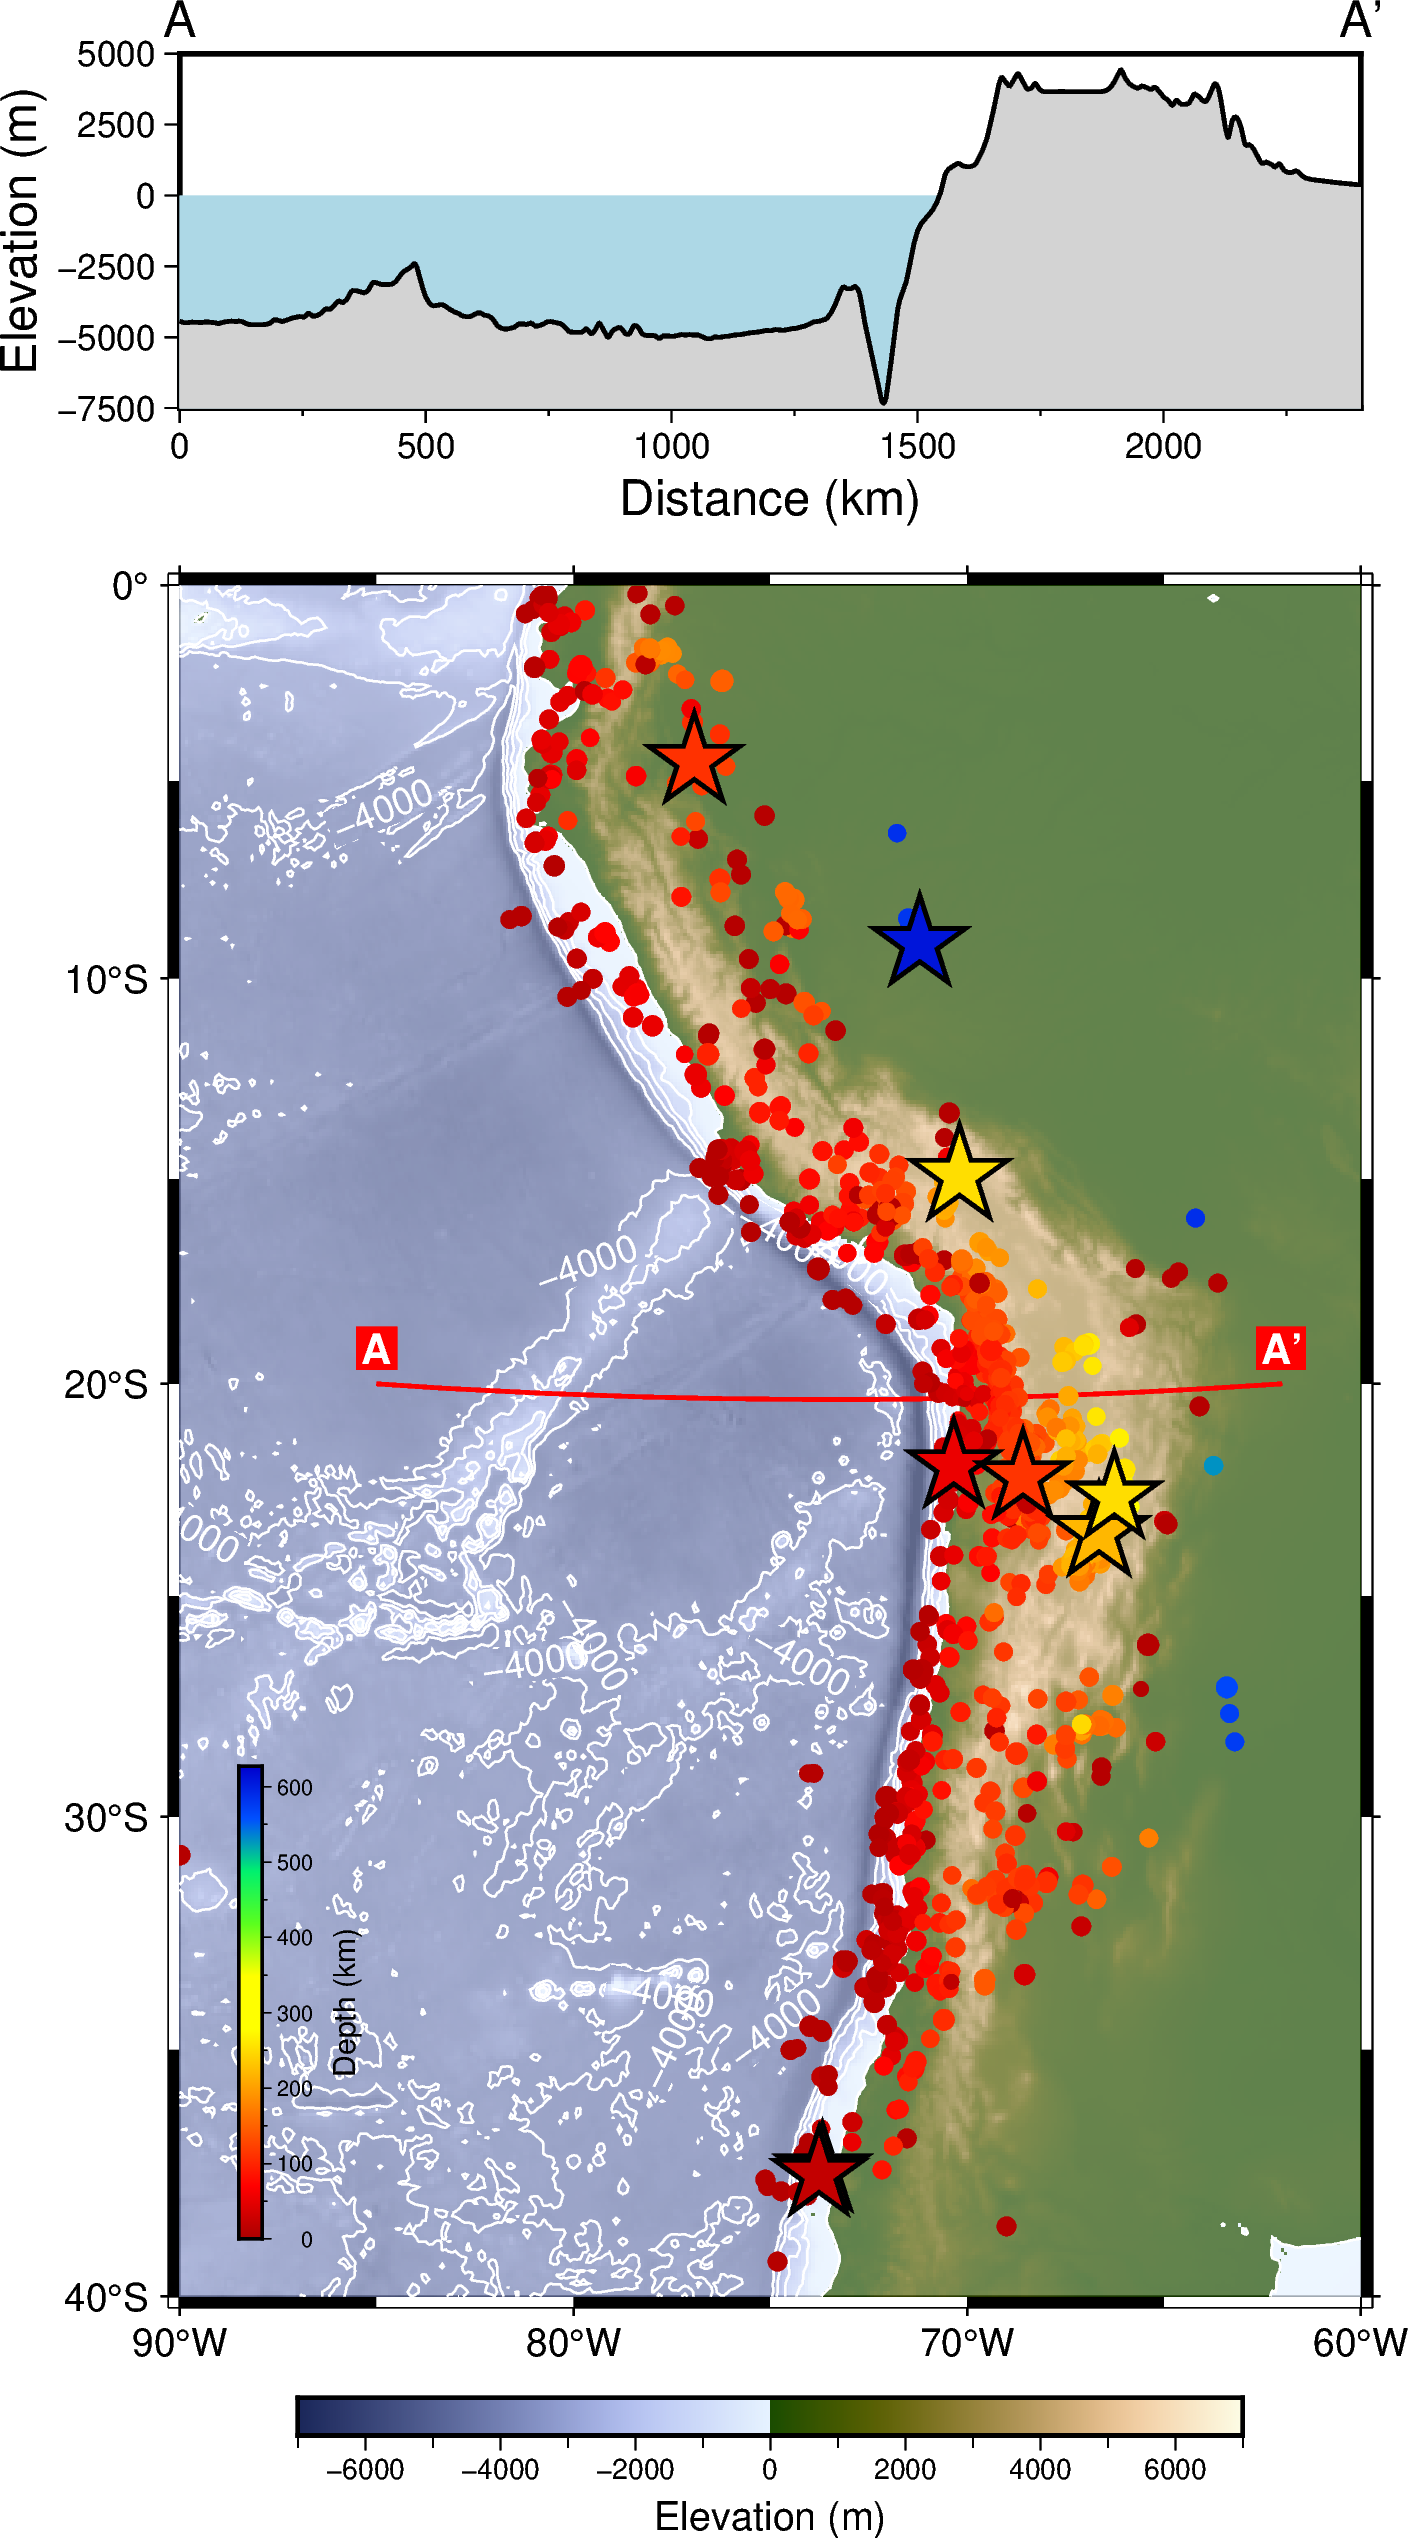

In [14]:
pygmt.makecpt(cmap="seis", series=[0, df["depth"].max()], )

tmpdf = df[df["mag"]<6]
fig.plot(x=tmpdf["lon"], 
         y=tmpdf["lat"], 
         style="cc", 
         size=np.log10(tmpdf["mag"])/4, 
         fill = tmpdf["depth"],
         cmap=True)

tmpdf = df[df["mag"]>=6]
fig.plot(x=tmpdf["lon"], 
         y=tmpdf["lat"], 
         style="ac", 
         size=np.log10(tmpdf["mag"]), 
         fill = tmpdf["depth"],
         pen="1p,black",
         cmap=True)

fig.colorbar(position="x0.5c/0.5c+w4c/0.2c+v+mc", frame=["a100f50+lDepth (km)"])
fig.show()

### 4.2 Add a beachball 

**where to place this part - difficult at the end of the JN because there we stop with the cartesian profil plot and the beachball has to be plotted into the map**

Plot the beachball for the Esmeraldas earthquake on 2022/03/27 at 04:28:12 (UTC)

Data from USGS

lon lat hdepth strike dip rake magnitude

-79.611 0.904 19.0 166 80 74 5.8

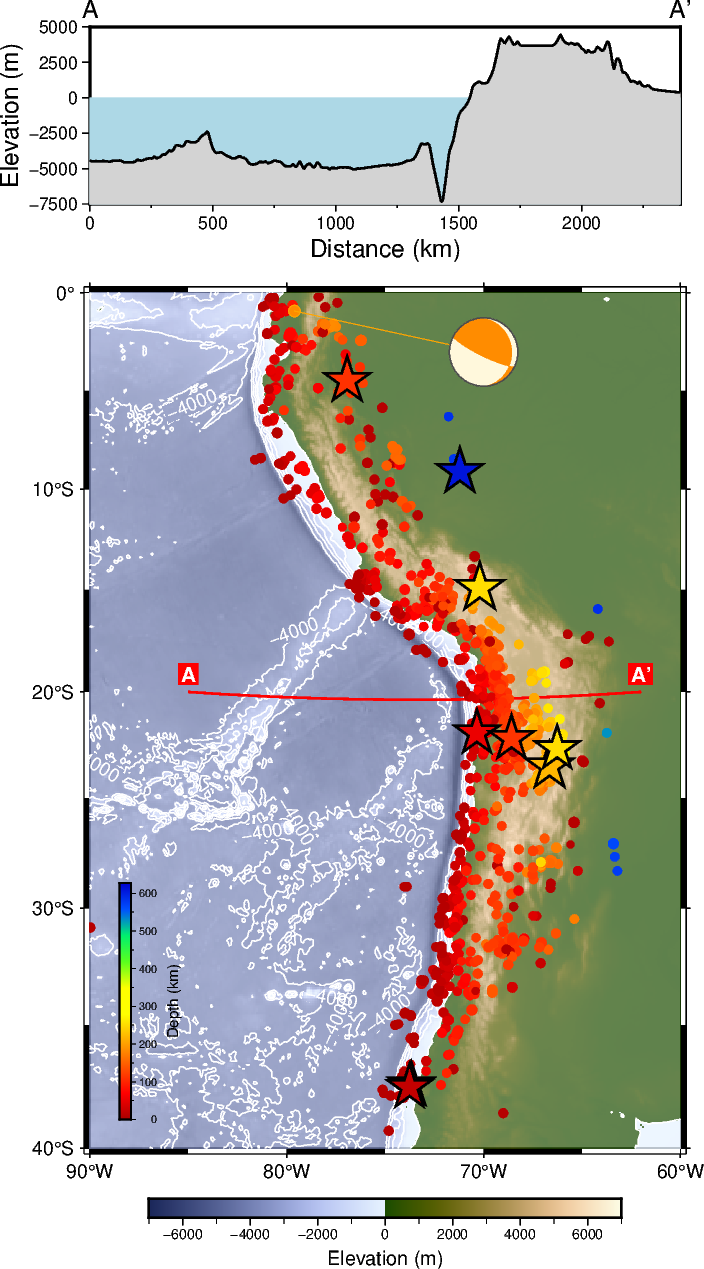

In [15]:
# Store focal mechanism parameters in a dictionary based on the Aki & Richards convention
focal_mechanism = {"strike": 116, "dip": 80, "rake": 74, "magnitude": 5.8}

# Pass the focal mechanism data through the spec parameter.
# In addition provide scale, event location, and event depth
fig.meca(
    spec=focal_mechanism,
    scale="1c",  # in centimeters
    longitude=-79.611,
    latitude=-0.904,
    depth=19,  # in kilometers
    # Fill compressive quadrants with color "darkorange" [Default is "black"]
    compressionfill="darkorange",
    # Fill extensive quadrants with color "cornsilk" [Default is "white"]
    extensionfill="cornsilk",
    # Draw a 0.5-points thick, darkgray ("gray30") solid outline via the pen parameter
    # [Default is "0.25p,black,solid"]
    pen="0.5p,gray30,solid",
    # Shift plotting location from event location
    plot_longitude=-70,
    plot_latitude=-3,
    # Add a connection line between the plotting and event locations
    offset="+p0.1p,orange+s0.2c",
)
 
fig.show(dpi=150)

## 5. Additional comments

Some helpful and interesting aspects:

- Use suitable colormaps for your data: [**Scientific colourmaps by Fabio Crameri**](https://www.fabiocrameri.ch/colourmaps/), see also the publications [Crameri et al. (2024)](https://doi.org/10.1002/cpz1.1126) and [Crameri et al. (2020)](https://doi.org/10.1038/s41467-020-19160-7)